In [44]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score


data_train_p = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_tech_scaled_p.parquet')
data_train_c = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_tech_scaled_c.parquet')

data_val_p = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_val_tech_scaled_p.parquet')
data_val_c = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_val_tech_scaled_c.parquet')

data_test_p = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_test_tech_scaled_p.parquet')
data_test_c = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_test_tech_scaled_c.parquet')

firm_data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Firm_variables/daily_firm_data_median_new.parquet')

data_train = pd.concat([data_train_p, data_train_c], axis=0)
data_val = pd.concat([data_val_p, data_val_c], axis=0)
data_test = pd.concat([data_test_p, data_test_c], axis=0)

# List of columns to drop
columns_to_drop = ['trading_days_till_exp'] + list(firm_data.columns[2:])
# columns_to_drop = ['trading_days_till_exp']


# Drop columns from datasets if they exist
data_train = data_train.drop(columns=columns_to_drop, errors='ignore')
data_val = data_val.drop(columns=columns_to_drop, errors='ignore')
data_test = data_test.drop(columns=columns_to_drop, errors='ignore')

# Ensure that data_val and data_test have the same column order as data_train
data_val = data_val[data_train.columns]
data_test = data_test[data_train.columns]



In [45]:
data_train_c = data_train[data_train['cp_flag'] == 'C']
data_train_p = data_train[data_train['cp_flag'] == 'P']

data_val_c = data_val[data_val['cp_flag'] == 'C']
data_val_p = data_val[data_val['cp_flag'] == 'P']



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6455.503513378331, tolerance: 2.4496654976258876
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/L

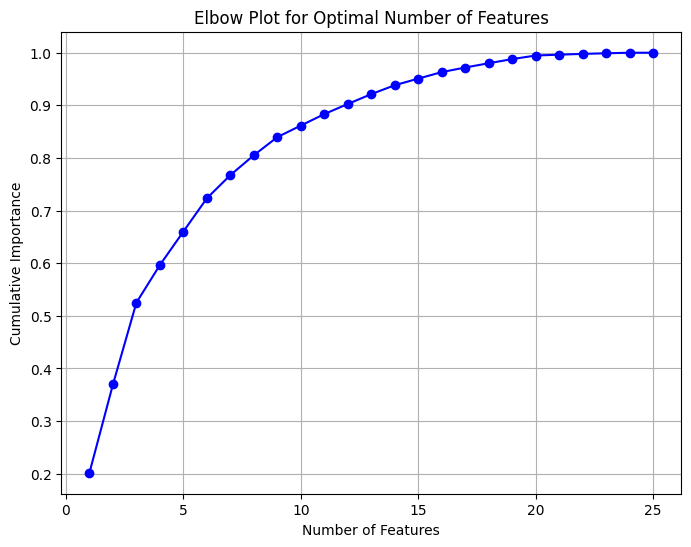

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6221.144847664989, tolerance: 2.425306833065213
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Li

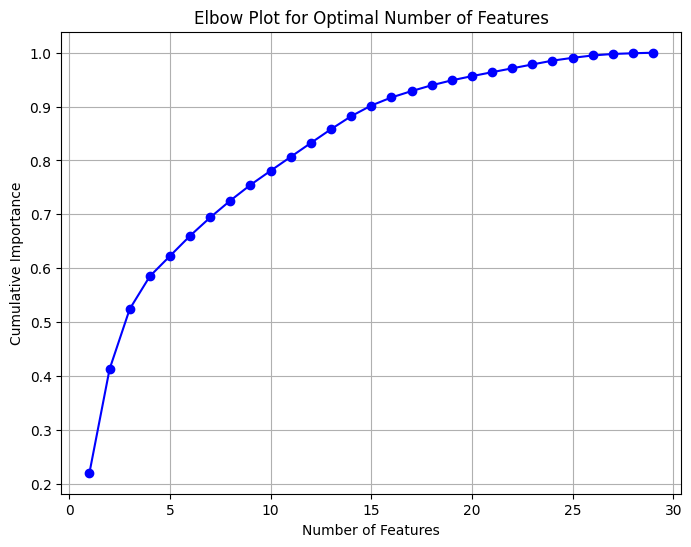

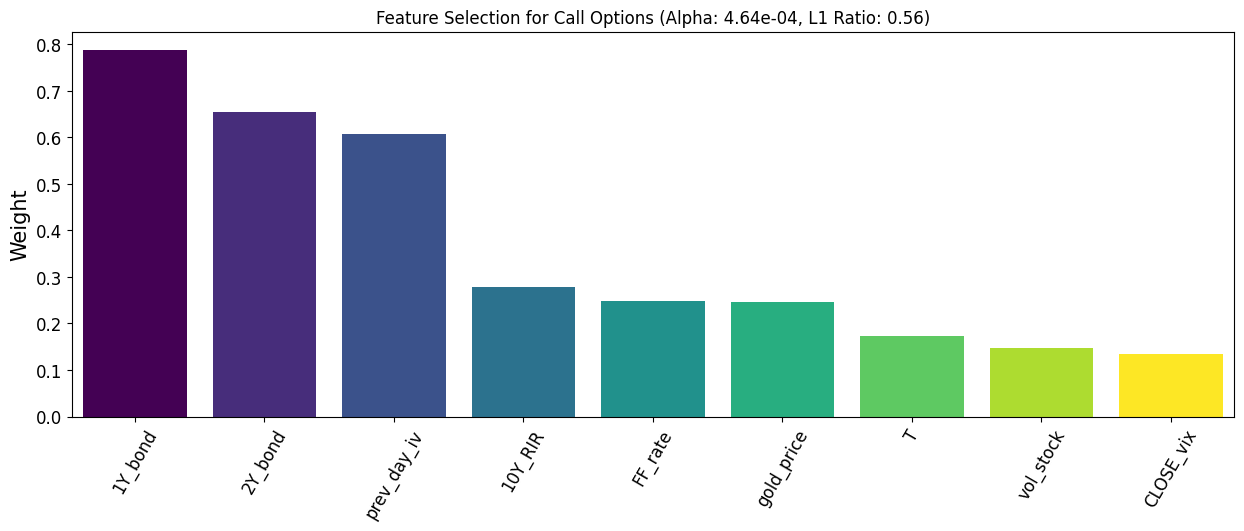

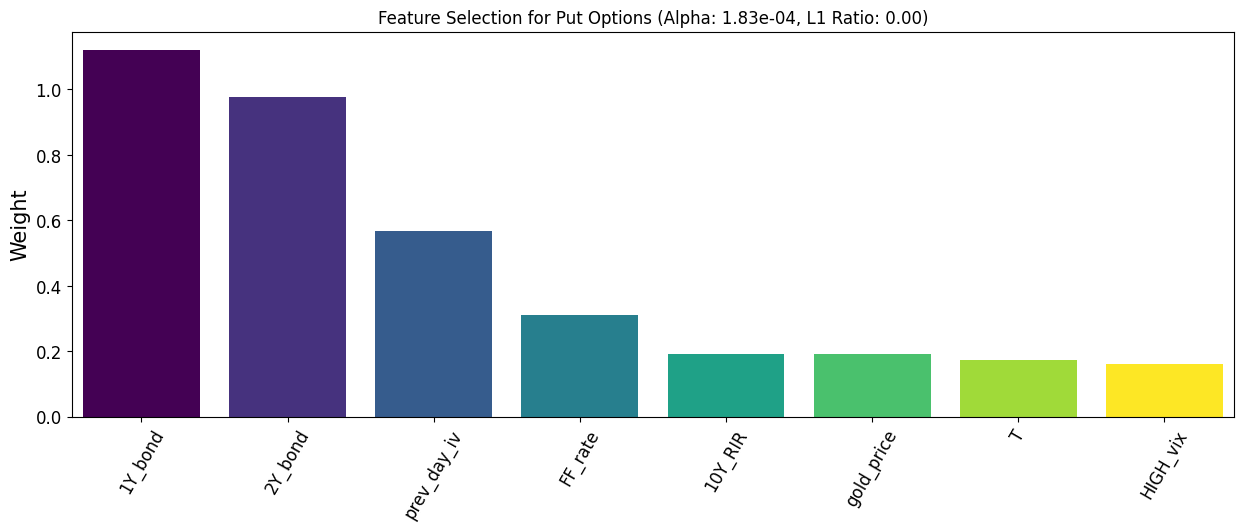

In [46]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNetCV
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import logging

# Suppress font warnings
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

def feature_selection(IV, combined_data, cp_flag):
    """
    Perform feature selection using ElasticNet regression for a specific cp_flag group and plot the elbow plot 
    to determine the optimal number of features.

    Parameters:
    IV (str): The name of the independent variable to predict.
    combined_data (pd.DataFrame): The combined dataset containing the features and the independent variable.
    cp_flag (str): The cp_flag for the group.

    Returns:
    pd.DataFrame: Sorted feature importances.
    """
    # Separate the independent variable (target) and the features
    data_y = combined_data[IV]
    features = combined_data.drop(columns=[IV, 'date', 'Ticker', 'cp_flag'])  # Adjust as necessary

    # Define the range for alpha and l1_ratio
    alphas = np.logspace(-10, 0, 100)
    l1_ratios = np.linspace(0, 1, 10)

    # Initialize and fit the ElasticNetCV model
    enet_cv_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)
    enet_cv_model.fit(features, data_y)

    # Get the best parameters
    best_alpha = enet_cv_model.alpha_
    best_l1_ratio = enet_cv_model.l1_ratio_

    # Get the coefficients from the model
    coef = enet_cv_model.coef_

    # Identify features with non-zero coefficients
    mask = coef != 0
    selected_features = features.columns[mask]

    # Create a DataFrame for the feature importances
    features_elnet = pd.DataFrame(data=np.absolute(coef[mask]), columns=["Importance"])
    features_elnet.index = selected_features

    # Sort the features by importance
    sorted_features_elnet = features_elnet.sort_values(by="Importance", ascending=False)

    # Calculate Cumulative Importance (used for the elbow method)
    sorted_features_elnet["Normalized Importance"] = sorted_features_elnet["Importance"] / sorted_features_elnet["Importance"].sum()
    cumulative_importance = sorted_features_elnet["Normalized Importance"].cumsum()
    
    # Elbow plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', color='b')
    plt.title('Elbow Plot for Optimal Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.grid(True)
    plt.show()

    # Manually determining the "elbow" (replace with any heuristic or observation)
    # You can use a rule-of-thumb, such as selecting the number of features before the curve levels off significantly
    elbow_point = int(input("Enter the number of features to select based on the elbow plot: "))

    # Select the top features based on the elbow point
    sorted_features_elnet = sorted_features_elnet.head(elbow_point)

    return sorted_features_elnet, best_alpha, best_l1_ratio


# Define the file paths for the CSV files
csv_file_path_call = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Features/features_call.csv'
csv_file_path_put = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Features/features_put.csv'

# Perform feature selection for calls
sorted_features_elnet_call, best_alpha_call, best_l1_ratio_call = feature_selection('impl_volatility', data_train_c, 'C')
# Perform feature selection for puts
sorted_features_elnet_put, best_alpha_put, best_l1_ratio_put = feature_selection('impl_volatility', data_train_p, 'P')

# Plot the feature importances for calls
colors = cm.viridis(np.linspace(0, 1, len(sorted_features_elnet_call)))
plt.figure(figsize=(15, 5))
plt.bar(sorted_features_elnet_call.index, sorted_features_elnet_call["Importance"], color=colors)
plt.ylabel("Weight", fontsize=15)
plt.xticks(rotation=60, fontsize=12)
plt.yticks(fontsize=12)
plt.margins(x=0.01)
plt.title(f"Feature Selection for Call Options (Alpha: {best_alpha_call:.2e}, L1 Ratio: {best_l1_ratio_call:.2f})")
plt.show()

# Plot the feature importances for puts
colors = cm.viridis(np.linspace(0, 1, len(sorted_features_elnet_put)))
plt.figure(figsize=(15, 5))
plt.bar(sorted_features_elnet_put.index, sorted_features_elnet_put["Importance"], color=colors)
plt.ylabel("Weight", fontsize=15)
plt.xticks(rotation=60, fontsize=12)
plt.yticks(fontsize=12)
plt.margins(x=0.01)
plt.title(f"Feature Selection for Put Options (Alpha: {best_alpha_put:.2e}, L1 Ratio: {best_l1_ratio_put:.2f})")
plt.show()

# Save the sorted features to CSV files
sorted_features_elnet_call.to_csv(csv_file_path_call)
sorted_features_elnet_put.to_csv(csv_file_path_put)


In [49]:
sorted_features_elnet_call.index

Index(['1Y_bond', '2Y_bond', 'prev_day_iv', '10Y_RIR', 'FF_rate', 'gold_price',
       'T', 'vol_stock', 'CLOSE_vix'],
      dtype='object')

In [50]:
call_features = sorted_features_elnet_call.index.tolist()
put_features = sorted_features_elnet_put.index.tolist()

# Validation set selection based on selection procedure

In [51]:
def apply_to_validation(IV, combined_data_val, selected_features, best_alpha, best_l1_ratio):
    """
    Apply the selected ElasticNet model to the validation data using the pre-selected features.

    Parameters:
    IV (str): The name of the independent variable to predict.
    combined_data_val (pd.DataFrame): The validation dataset containing the features and the independent variable.
    selected_features (pd.Index): The list of features selected by ElasticNet during training.
    best_alpha (float): The best alpha value found during training.
    best_l1_ratio (float): The best l1_ratio value found during training.

    Returns:
    pd.Series: The predicted values for the validation set.
    """
    # Separate the independent variable (target) and the features
    data_y_val = combined_data_val[IV]
    features_val = combined_data_val[selected_features]

    # Initialize the ElasticNet model with the best parameters from the training
    enet_model = ElasticNetCV(alphas=[best_alpha], l1_ratio=[best_l1_ratio], cv=5)

    # Fit the model to the validation data
    enet_model.fit(features_val, data_y_val)

    # Predict using the validation features
    predictions = enet_model.predict(features_val)

    return predictions


# Assuming you have your validation data sets standardized and loaded as `data_val_c` and `data_val_p`:

# Apply to validation set for calls
predictions_call_val = apply_to_validation('impl_volatility', data_val_c, sorted_features_elnet_call.index, best_alpha_call, best_l1_ratio_call)

# Apply to validation set for puts
predictions_put_val = apply_to_validation('impl_volatility', data_val_p, sorted_features_elnet_put.index, best_alpha_put, best_l1_ratio_put)

# Now you can compare the predicted values against the actual values in your validation set.


def evaluate_model_performance(actual, predicted):
    """
    Calculate and print RMSE and R² for the model predictions.

    Parameters:
    actual (pd.Series or np.array): The actual values of the independent variable.
    predicted (np.array): The predicted values from the model.

    Returns:
    rmse (float): The root mean square error.
    r2 (float): The R² score.
    """
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    # Calculate R² score
    r2 = r2_score(actual, predicted)
    
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    
    return rmse, r2

# Evaluate model performance for Call options
print("Performance on Validation Set - Call Options:")
rmse_call, r2_call = evaluate_model_performance(data_val_c['impl_volatility'], predictions_call_val)

# Evaluate model performance for Put options
print("\nPerformance on Validation Set - Put Options:")
rmse_put, r2_put = evaluate_model_performance(data_val_p['impl_volatility'], predictions_put_val)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 959.2304157376376, tolerance: 0.5878653880626632
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1046.206449672271, tolerance: 0.5965222539001532
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1008.9281122403456, tolerance: 0.5806771376521607
  model = cd_fast.enet_coor

Performance on Validation Set - Call Options:
RMSE: 0.2305
R²: 0.6564

Performance on Validation Set - Put Options:
RMSE: 0.2181
R²: 0.7342


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.060e+03, tolerance: 7.933e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [52]:
sorted_features_elnet_put.index

Index(['1Y_bond', '2Y_bond', 'prev_day_iv', 'FF_rate', '10Y_RIR', 'gold_price',
       'T', 'HIGH_vix'],
      dtype='object')

In [53]:
# Step 1: Calculate the mean and standard deviation of impl_volatility from the training data
call_iv_train_mean = data_train_c['impl_volatility'].mean()
call_iv_train_std = data_train_c['impl_volatility'].std()

put_iv_train_mean = data_train_p['impl_volatility'].mean()
put_iv_train_std = data_train_p['impl_volatility'].std()


In [54]:
def inverse_transform_predictions(predicted, mean, std):
    """
    Inverse transform the standardized predictions back to the original scale.

    Parameters:
    predicted (np.array): The predicted values from the standardized data.
    mean (float): The mean of the target variable in the training data.
    std (float): The standard deviation of the target variable in the training data.

    Returns:
    np.array: The inverse transformed predictions.
    """
    return predicted * std + mean

def apply_to_test(IV, combined_data_test, selected_features, best_alpha, best_l1_ratio):
    """
    Apply the ElasticNet model to the test data using the pre-selected features and best hyperparameters.

    Parameters:
    IV (str): The name of the independent variable to predict (e.g., 'impl_volatility').
    combined_data_test (pd.DataFrame): The test dataset containing the features and the independent variable.
    selected_features (pd.Index): The list of features selected by ElasticNet during training.
    best_alpha (float): The best alpha value found during training.
    best_l1_ratio (float): The best l1_ratio value found during training.

    Returns:
    np.array: The predicted values for the test set.
    """
    # Separate the independent variable (target) and the features
    data_y_test = combined_data_test[IV]
    features_test = combined_data_test[selected_features]

    # Initialize the ElasticNet model with the best parameters from the training phase
    enet_model = ElasticNetCV(alphas=[best_alpha], l1_ratio=[best_l1_ratio], cv=5)

    # Fit the model to the test data
    enet_model.fit(features_test, data_y_test)

    # Predict using the test features
    predictions = enet_model.predict(features_test)

    return predictions


# Step 3: Predict on the validation and test sets and inverse-transform the predictions

# For Calls
predictions_call_val = apply_to_validation('impl_volatility', data_val_c, sorted_features_elnet_call.index, best_alpha_call, best_l1_ratio_call)
predictions_call_test = apply_to_test('impl_volatility', data_test_c, sorted_features_elnet_call.index, best_alpha_call, best_l1_ratio_call)

# Inverse transform the predictions for Call options using the training set's mean and std
predictions_call_val_inverse = inverse_transform_predictions(predictions_call_val, call_iv_train_mean, call_iv_train_std)
predictions_call_test_inverse = inverse_transform_predictions(predictions_call_test, call_iv_train_mean, call_iv_train_std)

# For Puts
predictions_put_val = apply_to_validation('impl_volatility', data_val_p, sorted_features_elnet_put.index, best_alpha_put, best_l1_ratio_put)
predictions_put_test = apply_to_test('impl_volatility', data_test_p, sorted_features_elnet_put.index, best_alpha_put, best_l1_ratio_put)

# Inverse transform the predictions for Put options using the training set's mean and std
predictions_put_val_inverse = inverse_transform_predictions(predictions_put_val, put_iv_train_mean, put_iv_train_std)
predictions_put_test_inverse = inverse_transform_predictions(predictions_put_test, put_iv_train_mean, put_iv_train_std)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 959.2304157376376, tolerance: 0.5878653880626632
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1046.206449672271, tolerance: 0.5965222539001532
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1008.9281122403456, tolerance: 0.5806771376521607
  model = cd_fast.enet_coor

In [55]:
# Evaluate model performance on the validation set for Call options
print(f"\nNumber of features selected for Call options: {len(sorted_features_elnet_call.index)}")
print("Performance on Validation Set - Call Options:")
rmse_call_val, r2_call_val = evaluate_model_performance(data_val_c['impl_volatility'], predictions_call_val_inverse)

# Evaluate model performance on the test set for Call options
print("\nPerformance on Test Set - Call Options:")
rmse_call_test, r2_call_test = evaluate_model_performance(data_test_c['impl_volatility'], predictions_call_test_inverse)

# Evaluate model performance on the validation set for Put options
print(f"\nNumber of features selected for Put options: {len(sorted_features_elnet_put.index)}")
print("\nPerformance on Validation Set - Put Options:")
rmse_put_val, r2_put_val = evaluate_model_performance(data_val_p['impl_volatility'], predictions_put_val_inverse)

# Evaluate model performance on the test set for Put options
print("\nPerformance on Test Set - Put Options:")
rmse_put_test, r2_put_test = evaluate_model_performance(data_test_p['impl_volatility'], predictions_put_test_inverse)




Number of features selected for Call options: 9
Performance on Validation Set - Call Options:
RMSE: 0.2305
R²: 0.6564

Performance on Test Set - Call Options:
RMSE: 0.1467
R²: 0.6217

Number of features selected for Put options: 8

Performance on Validation Set - Put Options:
RMSE: 0.2181
R²: 0.7342

Performance on Test Set - Put Options:
RMSE: 0.1458
R²: 0.6509


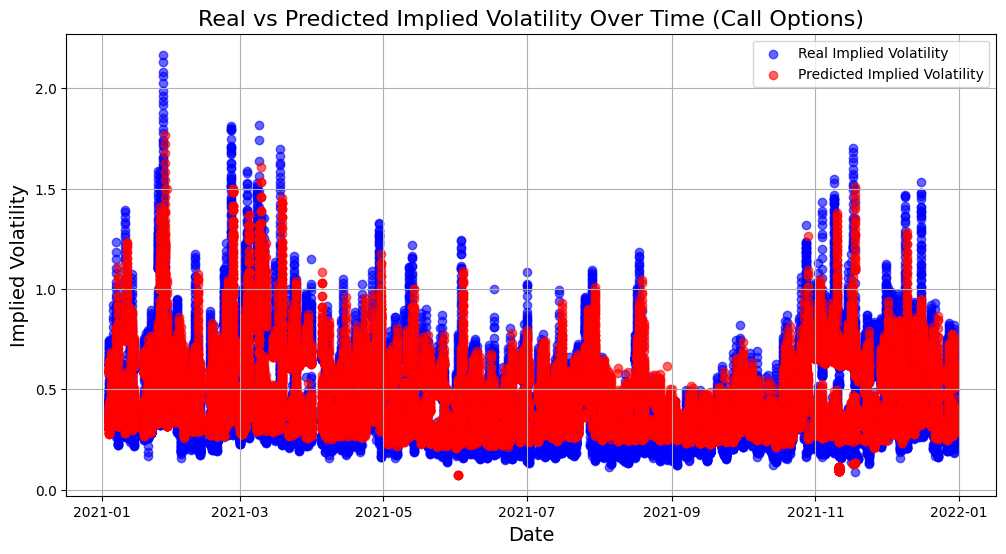

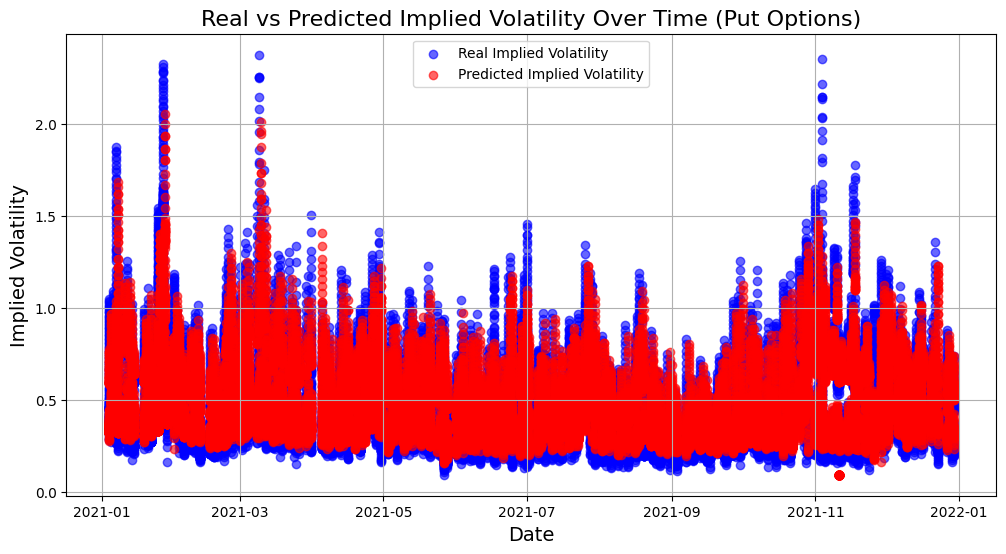

In [56]:
import matplotlib.pyplot as plt

def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    real_values (np.array or pd.Series): The real implied volatility values.
    predicted_values (np.array or pd.Series): The predicted implied volatility values.
    title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 6))
    
    # Scatter plot for Real Implied Volatility
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    
    # Scatter plot for Predicted Implied Volatility
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    
    # Labels and title
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    
    # Add a legend
    plt.legend()
    
    # Grid for better visualization
    plt.grid(True)
    
    # Display the plot
    plt.show()



# Plot for Call options test set
plot_real_vs_predicted(data_test_c, data_test_c['impl_volatility'], predictions_call_test_inverse, "Call Options")

# Plot for Put options test set
plot_real_vs_predicted(data_test_p, data_test_p['impl_volatility'], predictions_put_test_inverse, "Put Options")
